(convec_instability)=
# Convective instability -- lifting demo

This notebook shows how to obtain Thompkins Figure 3.47, p. 64 in stages, by lifting
a convectively unstable layer 

In [1]:
#calculate thermodynamic variables
#for a convectively unstable layer
from a405.thermo.constants import constants as c
from a405.skewT.fullskew import makeSkewWet,find_corners
from a405.thermo.thermlib import find_thetaet, find_rsat, tinvert_thetae, find_Td, find_lcl
from a405.thermo.thermlib import convertTempToSkew
from a405.thermo.thermlib import find_Tmoist
import numpy as np
import matplotlib.pyplot as plt

pa2hPa = 1.e-2
hPa2pa = 100.
np.seterr(all='ignore');


# # Reproduce the convective instability plot of Thompkins p. 64

```{figure}  images/convective_instability.jpg
---
width: 60%
name: thompkins_layer
alt: pha
---
Thompkins Figure 3.47
```

## Define functions to plot and lift soundings

In [2]:
def makePlot(ax,Temp=None,Tdew=None,Tpseudo=None,press=None,
             Tlcl=None,plcl=None,botLabel='LCL bot (835 hPa)',
             topLabel='LCL top (768 hPa)',skew=35):
  """
    Draw a tephigram of a convectively unstable layer with 
    Temp, Tdew, Tpseudo soundings, as well as the LCL of the top 
    and the bottom of the layer
    
    All temperatures in K, all pressure in hPa
  """
  xplot = convertTempToSkew(Tlcl[0] - c.Tc, plcl[0] * pa2hPa, skew)
  bot, = ax.plot(xplot, plcl[0] * pa2hPa, 'ro', markersize=12, markerfacecolor='r',label=botLabel)
  xplot = convertTempToSkew(Tlcl[-1] - c.Tc, plcl[-1] * pa2hPa, skew)
  #pdb.set_trace()
  top, = ax.plot(xplot, plcl[-1] * pa2hPa,'bd', markersize=12,
                 markerfacecolor='b',label = topLabel)
  xplot = convertTempToSkew(Tpseudo - c.Tc, press, skew)
  thetaEhandle, = ax.plot(xplot, press, 'c-', linewidth=2.5,label=r'$\theta_e$')
  xplot1 = convertTempToSkew(Temp - c.Tc, press, skew)
  Thandle, = ax.plot(xplot1, press, 'k-', linewidth=2.5,label='Temp (deg C)')
  xplot2 = convertTempToSkew(Tdew - c.Tc, press, skew)
  TdHandle, = ax.plot(xplot2, press, 'b--', linewidth=2.5,label='Dewpoint (deg C)')
  ax.legend(loc='best',numpoints=1)
  base=press[0]
  title_string = f'convectively unstable sounding: base at {base} hPa'
  ax.set_title(title_string)
  return ax

In [3]:
def lift_sounding(rTotal,theThetae,press):
  '''
  this function lifts a thetae sounding (rTotal,the_Thetae)
  to pressure level press

  Parameters
  ----------
    
  rTotal in kg/kg, theThetae in K press in hPa

  Returns
  -------
  temp,dewpoint and Tspeudo soundings for an rT,thetae sounding at pressure levels press
  '''
  Temp_rv_rl = apply(theThetae,rTotal,press*hPa2pa,the_fun=tinvert_thetae)
  Temp = np.array([item[0] for item in Temp_rv_rl])
  rv =  np.array([item[1] for item in Temp_rv_rl])
  Tdew = np.array(apply(rv,press*hPa2pa,the_fun=find_Td))
  Tpseudo = np.array(apply(theThetae,press*hPa2pa,the_fun=find_Tmoist))
  return Tdew,Temp,Tpseudo

## construct a 100 hPa thick layer with a convectively unstable sounding

In [4]:
Tbot = 20.
Ttop = 17.5
Tdewbot = 15
Tdewtop = 5.5

Pbot = 900.
Ptop = 800.

#calculate the temperature and dewpoint sounding
#assuming linear profiles
slope = (Ttop - Tbot) / (Ptop - Pbot)
press0 = np.arange(Pbot, Ptop - 10, -10)
Temp_sound = (Tbot + slope * (press0 - Pbot))
slope = (Tdewtop - Tdewbot) / (Ptop - Pbot)
Tdew_sound = (Tdewbot + slope * (press0 - Pbot))
Tdew_soundK = Tdew_sound + c.Tc
Temp_soundK = Temp_sound + c.Tc

In [5]:

def apply(*args,the_fun=None):
    """
    apply a function to a list of arguments, one row at a time
    the individual arguments are vectors of the same length, and
    are zipped together to form an array of n rows
    
    Parameters
    ----------
    
    *args: vectors
      args is a list of vectors like Temperature T, total water rT, pressure p
    the_fun: function that takes an individual set of numbers: i.e. the_fun(T,rT,p)
    
    Returns:
    
    out: ndarray
       the output of operating on each row with the_fun
      
    
    """
    row_wise = zip(*args)
    out=[the_fun(*row) for row in row_wise]
    out = np.asarray(out)
    return out

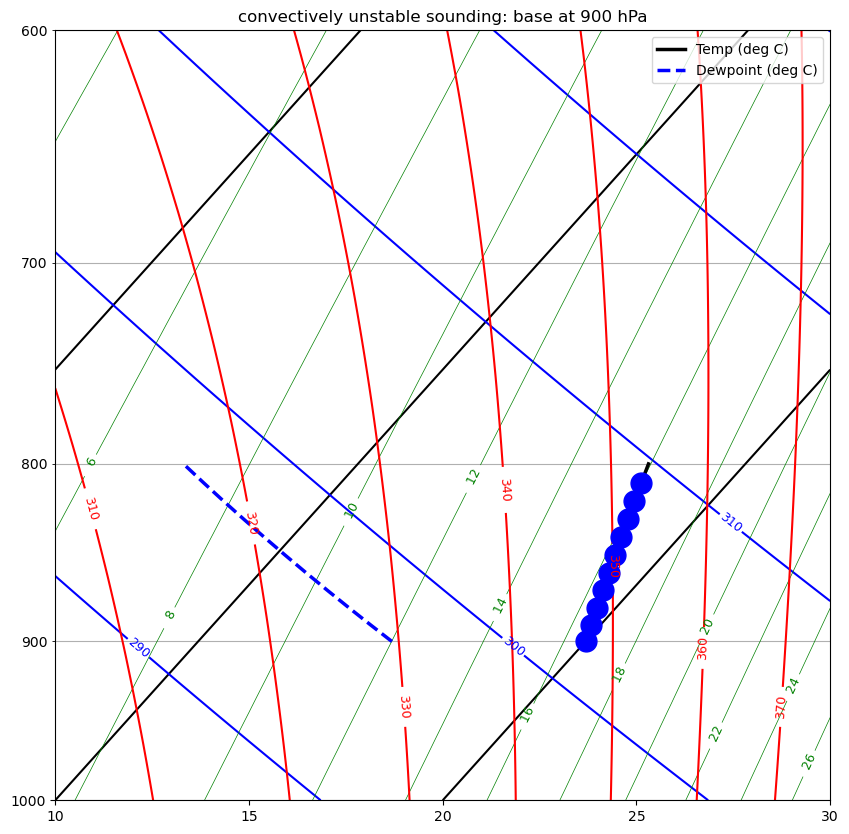

In [6]:

#
#figure 1: plot the T,Tdew profile only
#
skew=35
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
corners=[10,30]
ax, skew = makeSkewWet(ax,corners=corners,skew=skew)
#zoom the axis to focus on layer
xcorners=find_corners(corners,skew=skew)
ax.set(xlim=xcorners,ylim=[1000, 600])
xplot1 = convertTempToSkew(Temp_sound, press0, skew)
#plot() returns a list of handles for each line plotted
Thandle, = ax.plot(xplot1, press0, 'k-', linewidth=2.5,label='Temp (deg C)')
xplot2 = convertTempToSkew(Tdew_sound, press0, skew)
TdHandle, = ax.plot(xplot2, press0, 'b--', linewidth=2.5,label='Dewpoint (deg C)')
ax.set_title('convectively unstable sounding: base at 900 hPa')
ax.legend(numpoints=1,loc='best');
cs=convertTempToSkew
#fig.savefig('initial_sound.png')
#fig.savefig('initial_sound.pdf')
ax.plot(cs(Temp_sound[:-1],press0[:-1],skew),press0[:-1],'bo',markersize=15);

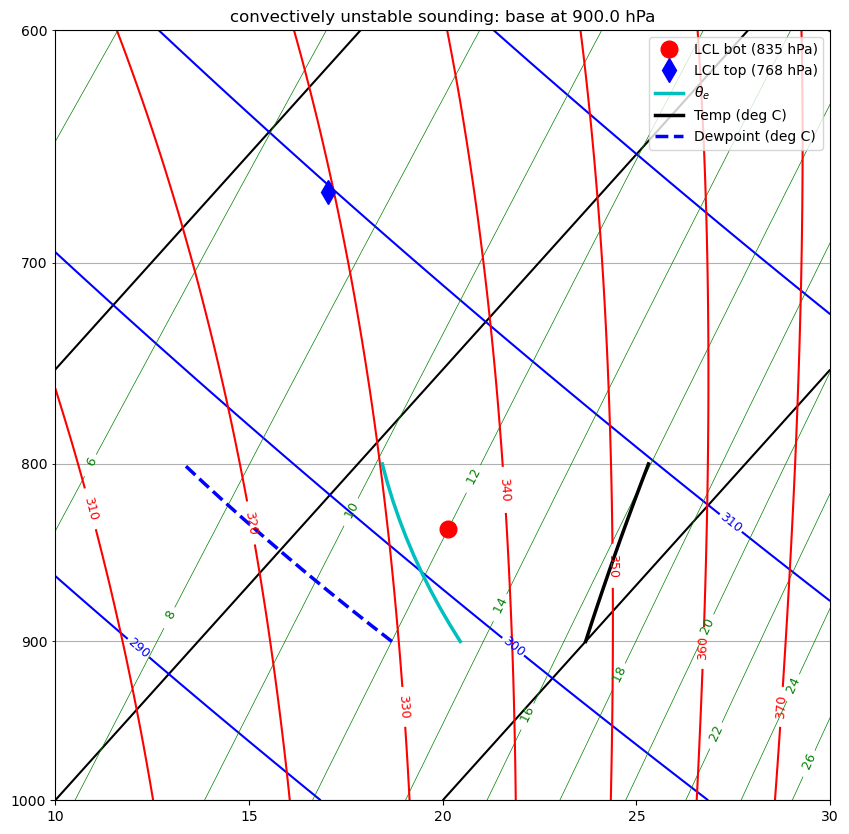

In [7]:

#
# figure 2, add thetae sounding and LCL for layer top and bottom
#


#
# calculate the rT_sound,thetae_sound sounding from the original dewpoint and temperture
#

rT_sound = apply(Tdew_soundK, (press0*hPa2pa),the_fun=find_rsat)
Tlcl_plcl = apply(Tdew_soundK, Temp_soundK, (press0*hPa2pa),the_fun=find_lcl)
Tlcl = np.array([item[0] for item in Tlcl_plcl])
plcl = np.array([item[1] for item in Tlcl_plcl])
thetae_sound = apply(Tdew_soundK,rT_sound,Temp_soundK, (press0*hPa2pa),the_fun=find_thetaet)
Tpseudo_sound = apply(thetae_sound, press0*hPa2pa, the_fun=find_Tmoist)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax, skew = makeSkewWet(ax,corners=corners,skew=skew)

fig_dict=dict(press=press0,Tpseudo=Tpseudo_sound,Temp=Temp_soundK,
              Tdew=Tdew_soundK,
              Tlcl=Tlcl,plcl=plcl,botLabel='LCL bot (835 hPa)',
              topLabel='LCL top (768 hPa)',skew=skew)
xcorners=find_corners(corners,skew=skew)
ax.set(xlim=xcorners,ylim=[1000, 600])
ax = makePlot(ax,**fig_dict);  


## Now lift the layer gradually

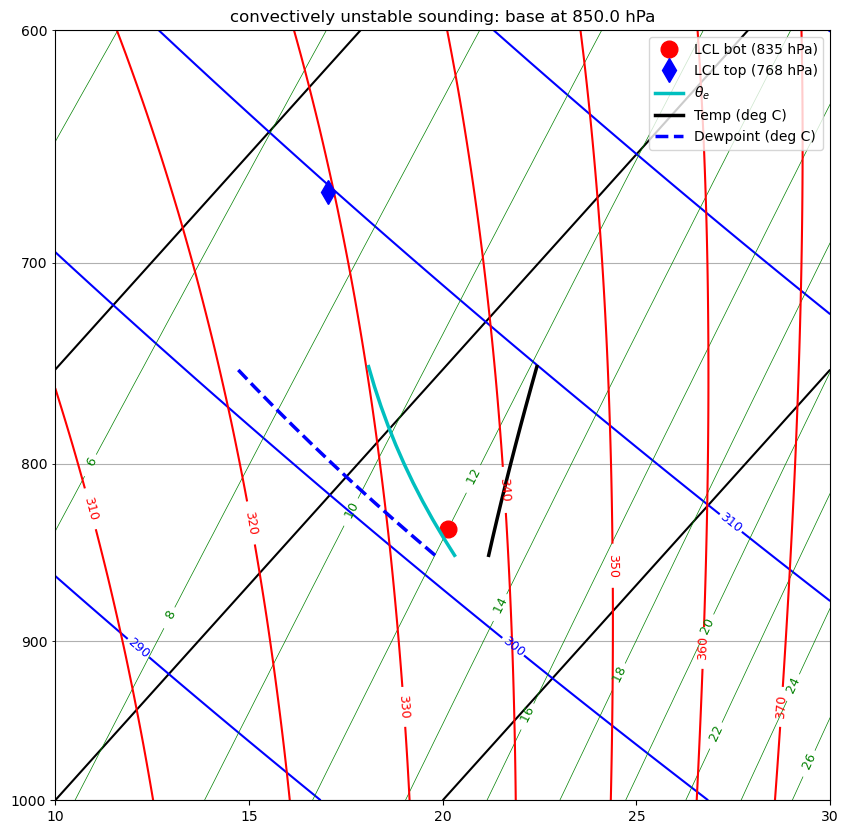

In [8]:

# #figure 3: lift cloud base by 50 hPa to 850 hPa

pressM50 = press0 - 50.
TdewM50, TempM50, TpseudoM50 = lift_sounding(rT_sound,thetae_sound,pressM50)
fig_dict.update(dict(press=pressM50,Temp=TempM50,Tdew=TdewM50,Tpseudo=TpseudoM50))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax, skew = makeSkewWet(ax,corners=corners,skew=skew)
ax = makePlot(ax,**fig_dict) 
ax.set(xlim=xcorners,ylim=[1000, 600])


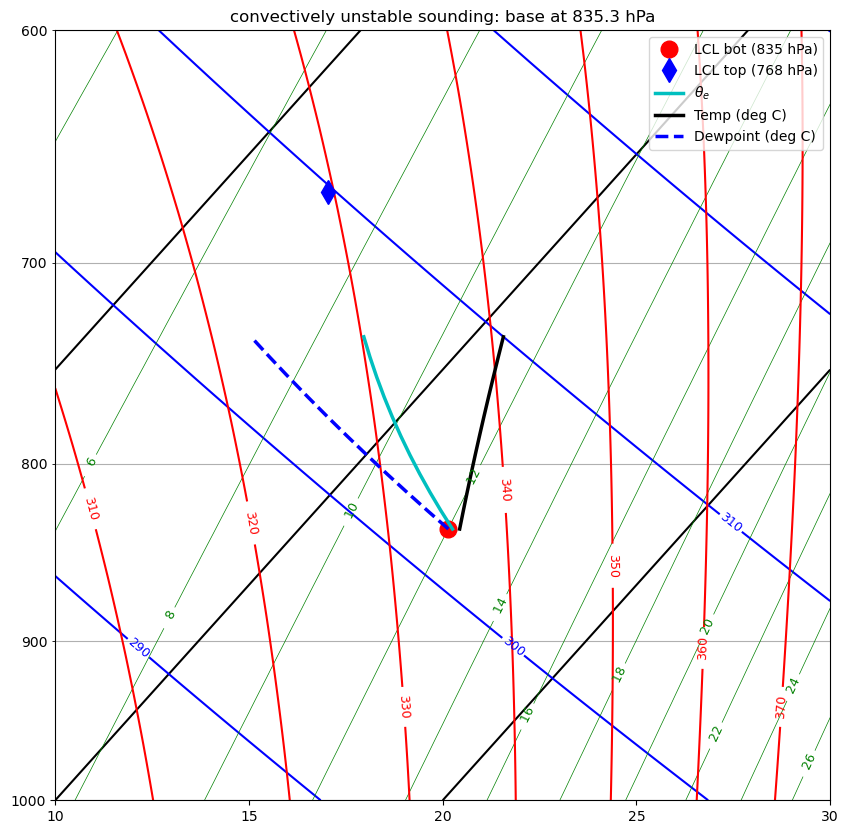

In [9]:

#
# figure 4 -- lift by 14.7 hPa to 835.3
#

pressM65 = pressM50 - 14.7
TdewM65, TempM65, TpseudoM65 = lift_sounding(rT_sound,thetae_sound,pressM65)
fig_dict.update(dict(press=pressM65,Temp=TempM65,Tdew=TdewM65,Tpseudo=TpseudoM65))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax, skew = makeSkewWet(ax,corners=corners,skew=skew)
ax = makePlot(ax,**fig_dict)   
ax.set(xlim=xcorners,ylim=[1000, 600])


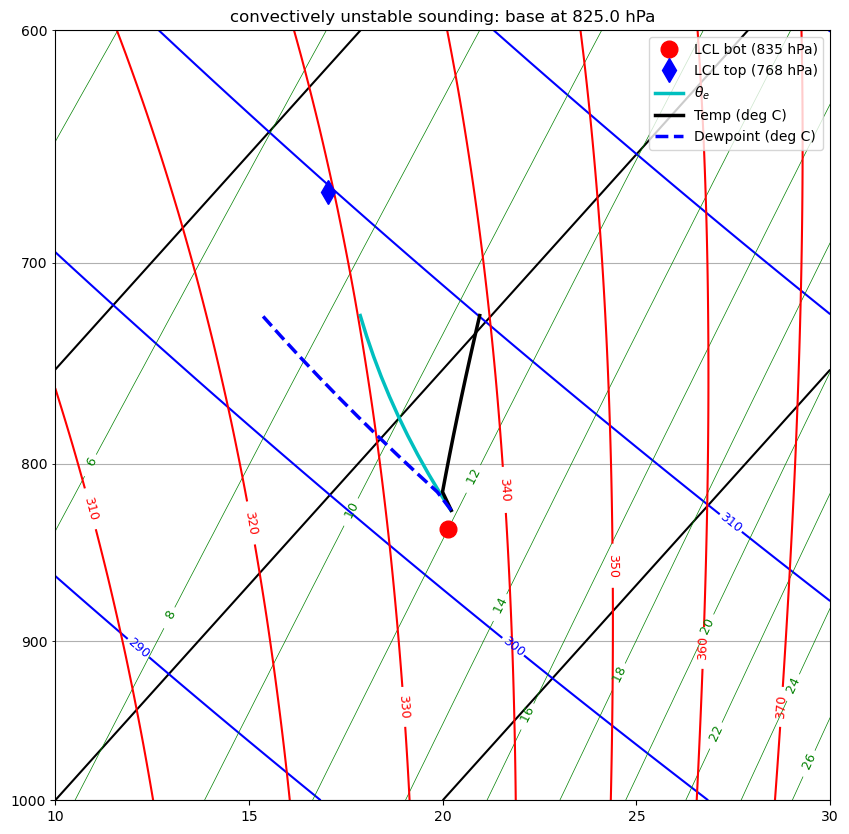

In [10]:

#
# figure 5 -- lift by 10.3 hPa to 825
#

pressM75 = pressM65 - 10.3
TdewM75, TempM75, TpseudoM75 = lift_sounding(rT_sound,thetae_sound,pressM75)
fig_dict.update(dict(press=pressM75,Temp=TempM75,Tdew=TdewM75,Tpseudo=TpseudoM75))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax, skew = makeSkewWet(ax,corners=corners,skew=skew)
ax = makePlot(ax,**fig_dict) 
ax.set(xlim=xcorners,ylim=[1000, 600])


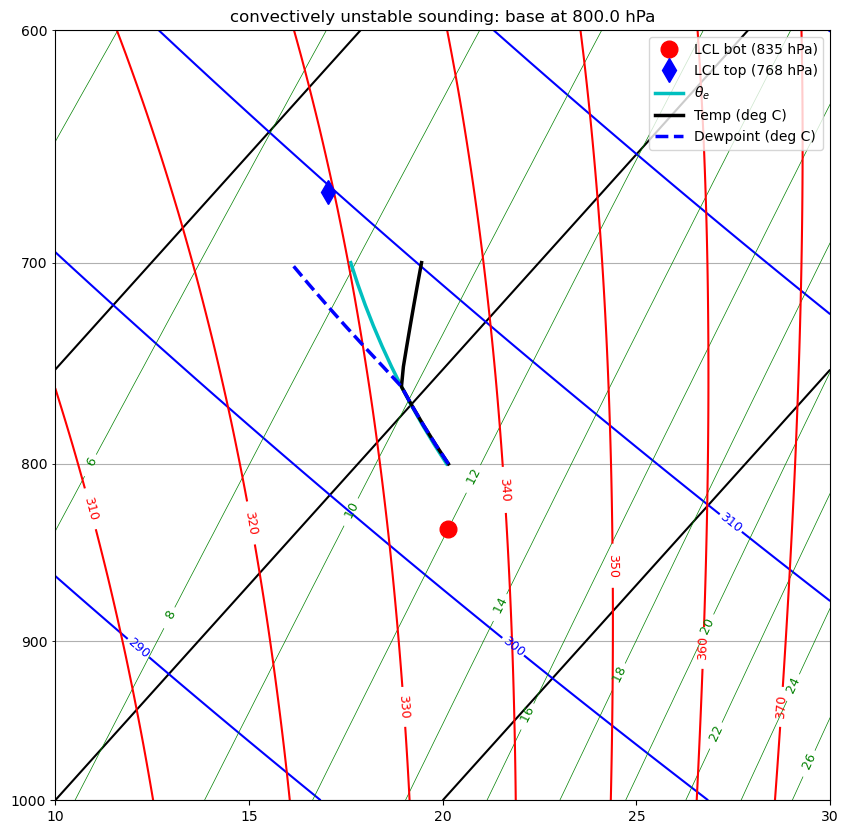

In [11]:

#
# figure 6 -- lift by 25 hPa to 800 hPa
#

pressM100 = pressM75 - 25
TdewM100, TempM100, TpseudoM100 = lift_sounding(rT_sound,thetae_sound,pressM100)
fig_dict.update(dict(press=pressM100,Temp=TempM100,Tdew=TdewM100,Tpseudo=TpseudoM100))


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax, skew = makeSkewWet(ax,corners=corners,skew=skew)
ax = makePlot(ax,**fig_dict) 
ax.set(xlim=xcorners,ylim=[1000, 600])


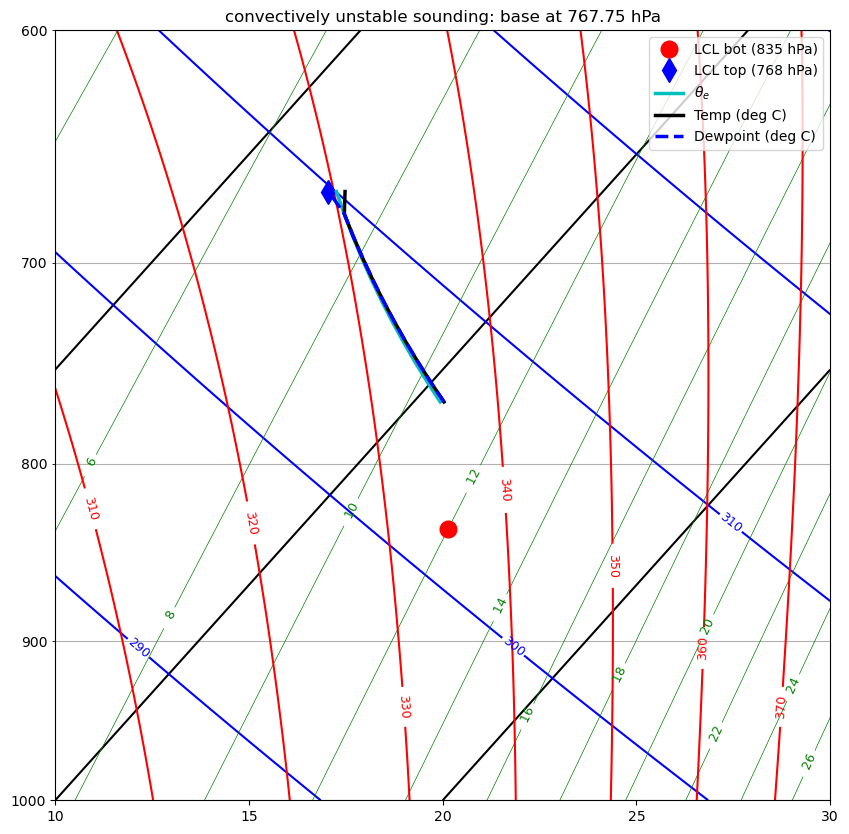

In [12]:

#
# figure 7 -- lift by 32.25 to 768 hPa
#

pressM132 = pressM100 - 32.25
TdewM132, TempM132, TpseudoM132 = lift_sounding(rT_sound,thetae_sound,pressM132)
fig_dict.update(dict(press=pressM132,Temp=TempM132,Tdew=TdewM132,Tpseudo=TpseudoM132))



fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax, skew = makeSkewWet(ax,corners=corners,skew=skew)
ax = makePlot(ax,**fig_dict)   
ax.set(xlim=xcorners,ylim=[1000, 600])
